In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import soundfile as sf
import librosa.display
from glob import glob
import os
from tqdm import tqdm

In [2]:
def splitData(X, t, testFraction=0.2, randomize = False):
    """
    Split the data randomly into training and test sets
    Use numpy functions only
    Inputs:
        X: (np array of len Nsamples) input feature vectors
        t: (np array of len Nsamples) targets; one hot vectors
        testFraction: (float) Nsamples_test = testFraction * Nsamples
    Outputs:
        X_train: training set
        X_test: test set
        t_train: training labels
        t_test: test labels
    """
    if randomize is False:
      tot_samples = np.random.RandomState(seed=42).permutation(len(X))
    else:
      tot_samples = np.random.permutation(len(X))

    X_train = []
    X_test = []
    t_train = []
    t_test = []
    
    test_samples = max(1,int(len(X)*testFraction))
    # print(tot_samples[:test_samples])
    # print(tot_samples[test_samples:])

    for i in range(test_samples):
      X_test.append(X[tot_samples[i]])
      t_test.append(t[tot_samples[i]])

    for i in range(test_samples,len(X)):
      X_train.append(X[tot_samples[i]])
      t_train.append(t[tot_samples[i]])
    
    return np.asarray(X_train), np.asarray(t_train), np.asarray(X_test), np.asarray(t_test)

def calc_spec(x):
    n_fft = 1024
    hop_length = 512
    win_length = 1024
    X = np.abs(librosa.stft(x, n_fft = n_fft, hop_length = hop_length, win_length = win_length, window='hann'))
    X = librosa.power_to_db(X**2,ref=np.max)
    return X

def audio2spec(x, norm=True, mfcc=True):
    
    '''
    Compute Mel-frequency cepstral coefficients (MFCCs)
    Inputs:
        x: np array of shape (Nsamples,)
    Output:
        X: (np array) spectrogram sequence
    '''
    X=[]
    for sample in x:
      if mfcc is False:
        X.append(calc_spec(sample))
      else:
        X.append(librosa.feature.mfcc(S=calc_spec(sample), n_mfcc=20))  
    if norm is True:
      X = (X-np.mean(X))/np.std(X)
    return np.asarray(X)

In [4]:
!pip install noisereduce

In [3]:
import librosa
import os
import noisereduce as nr
import glob
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from collections import defaultdict
import soundfile as sf
from tqdm import tqdm

In [4]:
def is_overlap(cstart_time, cend_time, start_time, end_time):
  if(cstart_time > end_time):
    return False
  if(cend_time < start_time):
    return False
  if(start_time > cstart_time and end_time < cend_time ):
    return True
  if(start_time > cstart_time):
    overlap = start_time - cstart_time
    if(overlap > 0.50 * (start_time - cend_time)):
      return True
    else:
      return False
  if(end_time < cend_time):
    overlap = cend_time - end_time
    if(overlap > 0.50 * (start_time - cend_time)):
      return True
    else:
      return False
  
  return True

def one_hot_enc(cl_name):
  if(cl_name == 'music'):
    return np.array([0,1,0])
  elif(cl_name == 'speech'):
    return np.array([1,0,0])
  else:
    return np.array([0,0,1])


def load_audio(filename, cls, Fs = 16000):
    # Return bins of size of 1000 corresponding to 
    x, _ = librosa.load(filename, sr=Fs)
    x = nr.reduce_noise(x, Fs)
    x = np.reshape(x[:K], (-1,SPLIT_SIZE))
    labels = np.zeros((N,3))
    for index, sub_audios in enumerate(x):
      class_assigned = False
      for tup in enumerate(cls):
        if(is_overlap(tup[1][0], tup[1][1], index*SPLIT_SIZE/K, (index+1)*SPLIT_SIZE/K)):
          labels[index] = one_hot_enc(tup[1][2])
          class_assigned = True
          break
      if(class_assigned == False):
          labels[index] = one_hot_enc('silence')
    
    return labels, x


def load_data(foldername, Fs=16000):
  '''
  Inputs: 
      foldername: (str) foldername
      Fs: (int) sampling rate
  
  Output:
      data: np array of data
  '''

  files = os.listdir(foldername+'/wav')
  df = pd.read_csv (foldername+'/labels.csv', usecols=['filename','onset','offset','class'])
  print(df.head())
  labels_data = df.to_numpy()
  data = dict()
  labels = defaultdict(list)
  
  for entry in labels_data:
    # print(entry[0])
    # print((entry[1],entry[2],entry[3]))
    labels[entry[0]].append((entry[1],entry[2],entry[3]))
  
  labels_list = []
  data_list = []

  for wav_file in tqdm(files):
    ls, audio = load_audio(foldername+"/wav/"+wav_file, labels[wav_file[:-4]], Fs)
    labels_list.append(ls)
    data_list.append(audio)

  labels_final = np.array(labels_list)
  data_final = np.array(data_list)
  labels_final = labels_final.reshape(N*len(files), 3)
  data_final = data_final.reshape(N*len(files), SPLIT_SIZE)
  # print(labels_final.shape)
  # print(data_final.shape)
  return labels_final, data_final


def reverse_one_hot(ohv):
  if(ohv[1] == 1):
    return "music"
  elif(ohv[0] == 1):
    return "speech"
  else:
    return "silence"

def save_data(train_labels, train_audios):
  for i in range(len(train_audios)):
    print(reverse_one_hot(train_labels[i]))
    sf.write('/content/drive/MyDrive/Sem 5/EE603/project/val_set/split_wavs/'+str(i)+'.wav', train_audios[i], 16000)

def get_mfcc(train_audios, n_mfcc=20, Fs=16000):
    mfccs=[]
    for audio in tqdm(train_audios):
      mfccs.append(librosa.feature.mfcc(audio, n_mfcc=n_mfcc, sr=Fs, n_fft=512))
      # mfccs.append(audio_mfcc)
    mfccs = np.array(mfccs)
    return mfccs

In [5]:
SAMPLING_RATE = 16000
AUDIO_DURATION = 10 #in seconds
FRAME_ACCURACY = 0.99
SPLIT_SIZE = 1000
MAX_SAMPLES = 0
K = int(AUDIO_DURATION*SAMPLING_RATE*FRAME_ACCURACY/SPLIT_SIZE)*SPLIT_SIZE
N = int(K/SPLIT_SIZE)

In [6]:
train_labels, train_audios = load_data('/content/drive/MyDrive/Sem 5/EE603/project/val_set')

  filename   onset  offset   class
0     S001  0.7545   1.963  speech
1     S001  3.0330   4.365  speech
2     S001  5.2850   6.591  speech
3     S001  7.6340   9.019  speech
4     S002  0.1580   1.060  speech


100%|██████████| 30/30 [00:17<00:00,  1.76it/s]


In [7]:
print(np.shape(train_labels), type(train_labels))
print(np.shape(train_audios), type(train_audios))

(4740, 3) <class 'numpy.ndarray'>
(4740, 1000) <class 'numpy.ndarray'>


In [8]:
Y_num = []

for label in tqdm(train_labels):
  if label[1] == 1:
    Y_num.append(2) #music
  elif label[0] == 1:
    Y_num.append(1) #speech
  else:
    Y_num.append(0) #silence

print(Y_num)

100%|██████████| 4740/4740 [00:00<00:00, 389106.37it/s]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [28]:
from scipy.stats import multivariate_normal 
from scipy.stats import mode

class GMM:
    def __init__(self, k, max_iter=5):
        self.k = k
        self.max_iter = int(max_iter) 

    def initialize(self, X):
        self.shape = X.shape 
        self.n, self.m = self.shape 
        self.phi = np.full(shape=self.k, fill_value=1/self.k) 
        self.weights = np.full(shape=self.shape, fill_value=1/self.k)
        random_row = np.random.randint(low=0, high=self.n, size=self.k)
        self.mu = [  X[row_index,:] for row_index in random_row ] 
        self.sigma = [ np.cov(X.T) for _ in range(self.k) ] 

    def e_step(self, X):
        self.weights = self.predict_proba(X)
        self.phi = self.weights.mean(axis=0)

    def m_step(self, X):
        for i in range(self.k):
            weight = self.weights[:, [i]]
            total_weight = weight.sum()
            self.mu[i] = (X * weight).sum(axis=0) / total_weight
            self.sigma[i] = np.cov(X.T,aweights=(weight/total_weight).flatten(), bias=True)

    def fit(self, X):
        self.initialize(X)
        for iteration in range(self.max_iter):
            self.e_step(X)
            self.m_step(X)
            
    def predict_proba(self, X):
        likelihood = np.zeros( (X.shape[0], self.k) ) 
        for i in range(self.k):
            distribution = multivariate_normal(mean=self.mu[i],cov=self.sigma[i], allow_singular=True)
            likelihood[:,i] = distribution.pdf(X) 
        numerator = likelihood * self.phi
        denominator = numerator.sum(axis=1)[:, np.newaxis]
        weights = numerator / denominator
        return weights
    
    def predict(self, X):
        weights = self.predict_proba(X)
        return np.argmax(weights, axis=1)

In [29]:
TESTFRACTION = 0.2
EPOCHS = 2*10**1

X_ = train_audios
Y_ = Y_num

X_train, t_train, X_test, t_test = splitData(X=X_, t=Y_, testFraction=TESTFRACTION, randomize=True)
print("check shapes after train test split")
print(np.shape(X_train), np.shape(t_train))
print(np.shape(X_test), np.shape(t_test))

X_train = audio2spec(x=X_train, norm=True, mfcc=True)
X_train = np.reshape(X_train, (np.shape(X_train)[0],-1))
print(np.shape(X_train), np.shape(t_train))
print("training") 

np.random.seed(42)
gmm = GMM(k=3, max_iter=EPOCHS)
gmm.fit(X_train)

X_test = audio2spec(x=X_test, norm=True, mfcc=True)
X_test = np.reshape(X_test, (np.shape(X_test)[0],-1))
print(np.shape(X_test), np.shape(t_test))
y_hat = gmm.predict(X_test)

from collections import Counter
print(Counter(y_hat))

check shapes after train test split
(3792, 1000) (3792,)
(948, 1000) (948,)


/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=1024 is too small for input signal of length=1000
  n_fft, y.shape[-1]


(3792, 40) (3792,)
training
(948, 40) (948,)
Counter({2: 792, 1: 156})


Accuracy: 0.6508438818565401


/usr/local/lib/python3.7/dist-packages/sklearn/utils/linear_assignment_.py:128: FutureWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  FutureWarning)


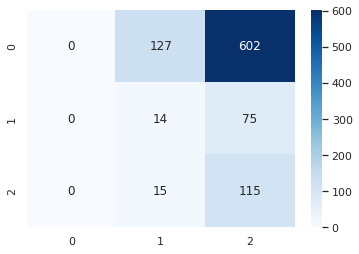

In [30]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(t_test, y_hat)
import seaborn as sns; sns.set()

ax = sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

from sklearn.utils.linear_assignment_ import linear_assignment
def _make_cost_m(cm):
    s = np.max(cm)
    return (- cm + s)

indexes = linear_assignment(_make_cost_m(cm))
js = [e[1] for e in sorted(indexes, key=lambda x: x[0])]
cm2 = cm[:, js]

print("Accuracy:",np.trace(cm2) / np.sum(cm2))